In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report,f1_score,recall_score ,precision_score,roc_curve,confusion_matrix, accuracy_score

In [2]:
#read in again to remove previous changes
new_columns = ['mean_profile', 'std_profile', 'kurtosis_profile', 'skewness_profile',
               'mean_DM_SNR', 'std_DM_SNR', 'kurtosis_DM_SNR', 'skewness_DM_SNR', 'target']

df = pd.read_csv('pulsar_data_train.csv')
df.columns = new_columns

In [3]:
df = df.dropna()

# Split the data into features and target
target = df['target']
features = df.drop(columns='target')

# First split: Training data and rest (validation data + test data)
X_train, X_rest, y_train, y_rest = train_test_split(features, target,
                                                    test_size=0.3,
                                                    random_state=42)

# Second split: Test data and validation data
X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest,
                                                test_size=0.5,
                                                random_state=42)

In [4]:
model_results = []

## SVM - baseline

In [5]:
# Create a pipeline that scales the data and applies SMOTE
pipe = make_pipeline(StandardScaler(), SMOTE(), SVC())

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# Make predictions on new data
y_pred_baseline = pipe.predict(X_test)

In [6]:
accuracy = accuracy_score(y_test, y_pred_baseline)
precision = precision_score(y_test, y_pred_baseline)
recall = recall_score(y_test, y_pred_baseline)
f1_scr = f1_score(y_test, y_pred_baseline)

scores = {'name': 'SVM_baseline',
          'accuracy': accuracy,
          'precision': precision,
          'recall': recall,
          'F1': f1_scr,
          }

model_results.append(scores)

# show results
pd.DataFrame(model_results).T

,0
name,SVM_baseline
accuracy,0.976995
precision,0.855072
recall,0.907692
F1,0.880597


## SVM with GridSearch

In [7]:
# Define the parameter grid for the inner loop
param_grid = {
    'svc__C': [0.01, 0.1, 1, 10, 100],
    'svc__kernel': ['rbf'], # 'linear', 'poly', 'sigmoid'
    'svc__gamma': [0.01, 0.1, 1, 10, 100],
    'svc__degree': [2, 3, 4]
}


# Create a GridSearchCV object for the inner loop
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid.fit(X_train, y_train)

# Remove the 'svc__' prefix from the keys in best_params_
best_params = {key.split('__')[1]: value for key, value in grid.best_params_.items()}

# Create a pipeline with the best hyperparameters from the grid search
pipe_grid = make_pipeline(StandardScaler(), SMOTE(), SVC(**best_params))

# Fit the pipeline to the training data
pipe_grid.fit(X_train, y_train)

# Make predictions on new data using the pipeline with the best hyperparameters from the grid search
y_pred_grid = pipe_grid.predict(X_test)


In [8]:
print(best_params)

{'C': 1, 'degree': 4, 'gamma': 0.1, 'kernel': 'rbf'}


In [9]:
accuracy = accuracy_score(y_test, y_pred_grid)
precision = precision_score(y_test, y_pred_grid)
recall = recall_score(y_test, y_pred_grid)
f1_scr = f1_score(y_test, y_pred_grid)

scores = {'name': 'SVM_grid',
          'accuracy': accuracy,
          'precision': precision,
          'recall': recall,
          'F1': f1_scr,
          }

model_results.append(scores)

# show results
pd.DataFrame(model_results).T

,0,1
name,SVM_baseline,SVM_grid
accuracy,0.976995,0.977714
precision,0.855072,0.856115
recall,0.907692,0.915385
F1,0.880597,0.884758


## SVM with RandomizedSearch

In [10]:
# Create a RandomizedSearchCV object for the inner loop
random_search = RandomizedSearchCV(pipe, param_distributions=param_grid, n_iter=10, cv=5, n_jobs=-1)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Remove the 'svc__' prefix from the keys in best_params_
best_params = {key.split('__')[1]: value for key, value in random_search.best_params_.items()}

# Create a pipeline with the best hyperparameters from the random search
pipe_random_search = make_pipeline(StandardScaler(), SMOTE(), SVC(**best_params))

# Fit the pipeline to the training data
pipe_random_search.fit(X_train, y_train)

# Make predictions on new data using the pipeline with the best hyperparameters from the random search
y_pred_random_search = pipe_random_search.predict(X_test)

In [11]:
print(best_params)

{'kernel': 'rbf', 'gamma': 0.01, 'degree': 3, 'C': 10}


In [12]:
accuracy = accuracy_score(y_test, y_pred_random_search)
precision = precision_score(y_test, y_pred_random_search)
recall = recall_score(y_test, y_pred_random_search)
f1_scr = f1_score(y_test, y_pred_random_search)

scores = {'name': 'SVM_ran_search',
          'accuracy': accuracy,
          'precision': precision,
          'recall': recall,
          'F1': f1_scr,
          }

model_results.append(scores)

# show results
pd.DataFrame(model_results).T

,0,1,2
name,SVM_baseline,SVM_grid,SVM_ran_search
accuracy,0.976995,0.977714,0.976995
precision,0.855072,0.856115,0.855072
recall,0.907692,0.915385,0.907692
F1,0.880597,0.884758,0.880597


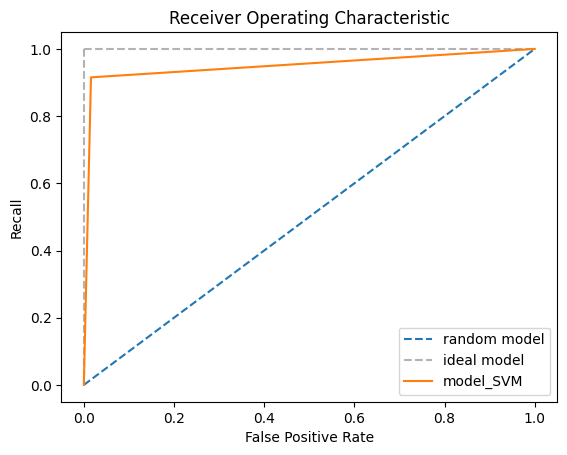

In [16]:
# calculate roc curve values
false_positive_rate, recall, threshold = roc_curve(y_test,
                                                   #y_pred_proba[:, 1],
                                                   y_pred_grid,
                                                   drop_intermediate=False) 

# figure and axes intialisation
fig, ax = plt.subplots()

# reference lines
ax.plot([0, 1], ls = "--", label='random model')  # blue diagonal
ax.plot([0, 0], [1, 0], c=".7", ls='--', label='ideal model')  # grey vertical
ax.plot([1, 1], c=".7", ls='--')  # grey horizontal

# roc curve
ax.plot(false_positive_rate, recall, label='model_SVM')

# labels
ax.set_title("Receiver Operating Characteristic")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("Recall")
ax.legend();

<Axes: >

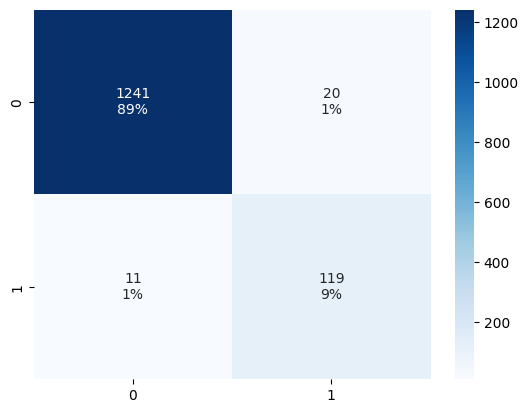

In [23]:
# generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_grid)

# create heatmap with count and percentage
percentages = np.round(cf_matrix / np.sum(cf_matrix), 2)
annot = np.empty_like(cf_matrix).astype(str)
for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[1]):
        annot[i, j] = f'{cf_matrix[i, j]}\n{percentages[i, j]:.0%}'
sns.heatmap(cf_matrix, annot=annot, fmt='', cmap='Blues')

## TODO:
- rename from imblearn.pipeline import make_pipeline and every use of make_pipeline
- rename models
- cleanup imports
+ add ROC 
- improve Confusion Matrix (use a differnt one, 
                            add labels, title, etc)

runtime of notebook: ~5min